In [1]:
import numpy as np
import os
import pandas as pd
import math

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

from eventio.simtel.simtelfile import SimTelFile
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy.interpolate import interp1d

In [2]:
def read_data(filename, n_skip):
   
    wavelength = []
    transmissivity = []

    with open(filename, "r") as file:
        lines = file.readlines()[n_skip:]
        for line in lines:
            words = line.split()
            #print(words[0], ' ; ', words[1])    
            wavelength.append(float(words[0]))
            transmissivity.append(float(words[1]))
                
    return wavelength, transmissivity

In [3]:
nuv_hd_40um = np.loadtxt('/home/andrii/work/terzina/NUV-HD_3x3_40um.dat', dtype=float, comments='#', delimiter = ' ')
nuv_hd_75um = np.loadtxt('/home/andrii/work/terzina/NUV-HD_6x6_75um.out', dtype=float, comments='#', delimiter = ' ')


In [4]:
nuv_hd_75_wavelength = np.append(nuv_hd_75um[:-6,0], nuv_hd_40um[-13:,0])
nuv_hd_75_pde = np.append(nuv_hd_75um[:-6,2], nuv_hd_40um[-13:,2])

In [5]:
f_nuv_hd_40um = interp1d(nuv_hd_40um[:,0], 0.01*nuv_hd_40um[:,2], kind='cubic')
f_nuv_hd_75um = interp1d(nuv_hd_75_wavelength, 0.01*nuv_hd_75_pde, kind='cubic')

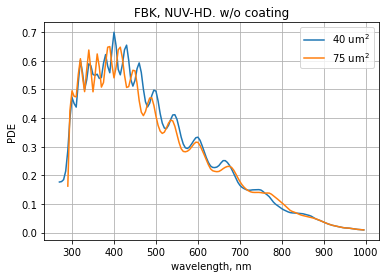

In [6]:
wl_40um = np.arange(nuv_hd_40um[0,0], nuv_hd_40um[-1,0], 5)
wl_75um = np.arange(nuv_hd_75_wavelength[0], nuv_hd_75_wavelength[-1], 5)

plt.plot(wl_40um, f_nuv_hd_40um(wl_40um), label = '40 um$^2$')
plt.plot(wl_75um, f_nuv_hd_75um(wl_75um), label = '75 um$^2$')
plt.grid()
plt.ylabel('PDE')
plt.xlabel('wavelength, nm')
plt.legend()
plt.title('FBK, NUV-HD. w/o coating')
plt.savefig('PDE_FbK.png', dpi = 200)

In [7]:
wl_nsb, nsb = read_data('/home/andrii/work/sim_telarray/analysis/spectrums/Spectra_NSB_ref.txt', 4)

In [8]:
wl_borofloat, borofloat = read_data('/home/andrii/work/sim_telarray/analysis/spectrums/Borofloat_2ndwdw_SST1M.dat', 4)

In [9]:
f_borofloat = interp1d(wl_borofloat, borofloat, kind='cubic')

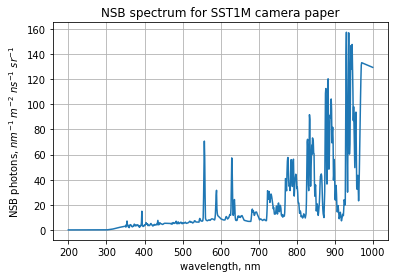

In [10]:
plt.plot(wl_nsb, nsb, '-')
plt.grid()
plt.ylabel('NSB photons, $nm^{-1}$ $m^{-2}$ $ns^{-1}$ $sr^{-1}$')
plt.xlabel('wavelength, nm')
plt.title('NSB spectrum for SST1M camera paper')
plt.savefig('NSB_spectrum.png', dpi = 200)

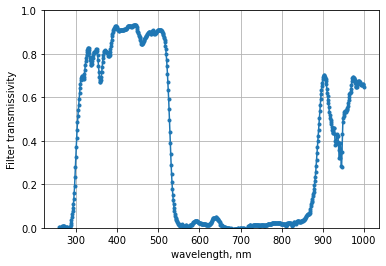

In [11]:
wl_bf = np.arange(wl_borofloat[0], wl_borofloat[-1], 0.05)

plt.plot(wl_borofloat, borofloat, '.-')
#plt.plot(wl_bf, f_borofloat(wl_bf))
plt.grid()
plt.ylabel('Filter transmissivity')
plt.xlabel('wavelength, nm')
plt.ylim(0, 1)
plt.savefig('Borofloat_transmissivity.png', dpi = 200)

In [12]:
nsb_integral = np.zeros(len(nsb))
nsb_integral_pde_40um = np.zeros(len(nsb))
nsb_integral_pde_75um = np.zeros(len(nsb))

nsb_integral_pde_40um_bf = np.zeros(len(nsb))
nsb_integral_pde_75um_bf = np.zeros(len(nsb))

for point in range(len(nsb)):
    if point>0:
        wl_test = nsb[point]
        nsb_integral[point] = nsb_integral[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]
        if wl_nsb[point]> wl_40um[0]:
            nsb_integral_pde_40um[point] = nsb_integral_pde_40um[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]*f_nuv_hd_40um(wl_nsb[point])
            nsb_integral_pde_40um_bf[point] = nsb_integral_pde_40um_bf[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]*f_nuv_hd_40um(wl_nsb[point])*f_borofloat(wl_nsb[point])
        
        if wl_nsb[point]> wl_75um[0]:
            nsb_integral_pde_75um[point] = nsb_integral_pde_75um[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]*f_nuv_hd_75um(wl_nsb[point])
            nsb_integral_pde_75um_bf[point] = nsb_integral_pde_75um_bf[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]*f_nuv_hd_75um(wl_nsb[point])*f_borofloat(wl_nsb[point])

In [13]:
nsb_photons = nsb_integral[-1]*6*(3.14*pow(3./930.,2))*0.11
print('NBS in photons : ', nsb_photons, ' GHz')

NBS in photons :  0.3807142140640582  GHz


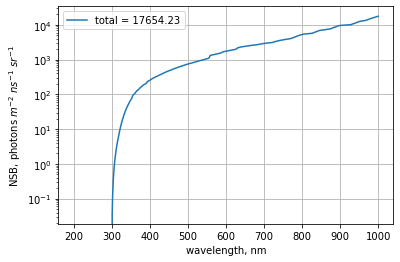

In [14]:
plt.plot(wl_nsb,nsb_integral, label = 'total = {:.2f}'.format(nsb_integral[-1]))
plt.yscale('log')
plt.ylabel('NSB, photons $m^{-2}$ $ns^{-1}$ $sr^{-1}$')
plt.xlabel('wavelength, nm')
plt.grid()
plt.legend()
plt.savefig('NSB_Integrated.png', dpi = 200)

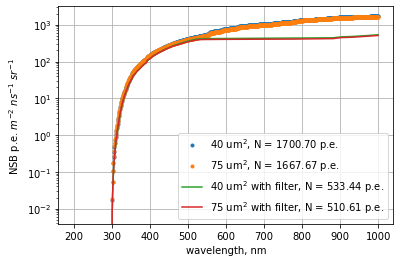

In [15]:
plt.plot(wl_nsb, nsb_integral_pde_40um, '.', label = '40 um$^2$, N = {:.2f} p.e.'.format(nsb_integral_pde_40um[-1]))
plt.plot(wl_nsb, nsb_integral_pde_75um, '.', label = '75 um$^2$, N = {:.2f} p.e.'.format(nsb_integral_pde_75um[-1]))

plt.plot(wl_nsb, nsb_integral_pde_40um_bf, '-', label = '40 um$^2$ with filter, N = {:.2f} p.e.'.format(nsb_integral_pde_40um_bf[-1]))
plt.plot(wl_nsb, nsb_integral_pde_75um_bf, '-', label = '75 um$^2$ with filter, N = {:.2f} p.e.'.format(nsb_integral_pde_75um_bf[-1]))


plt.yscale('log')
plt.ylabel('NSB p.e. $m^{-2}$ $ns^{-1}$ $sr^{-1}$')
plt.xlabel('wavelength, nm')
plt.grid()
plt.legend()
plt.savefig('NSB_Integrated_with_filter_pe.png', dpi = 200)

In [16]:
nsb_pe = nsb_integral_pde_40um[-1]*6*(3.14*pow(3./930.,2))*0.11
print('NBS in photons : ', nsb_pe, ' GHz, for 40 um device')

NBS in photons :  0.03667556661803739  GHz, for 40 um device


In [17]:
nsb_pe = nsb_integral_pde_40um_bf[-1]*6*(3.14*pow(3./930.,2))*0.11
print('NBS in photons : ', nsb_pe, ' GHz, for 40 um device')

NBS in photons :  0.011503608069519168  GHz, for 40 um device


In [18]:
nsb_pe = nsb_integral_pde_75um[-1]*6*(3.14*pow(3./930.,2))*0.11
print('NBS in photons : ', nsb_pe, ' GHz, for 75 um device')

NBS in photons :  0.035963265014153596  GHz, for 75 um device


In [19]:
nsb_pe = nsb_integral_pde_75um_bf[-1]*6*(3.14*pow(3./930.,2))*0.11
print('NBS in photons : ', nsb_pe, ' GHz, for 75 um device')

NBS in photons :  0.011011335732781086  GHz, for 75 um device


In [21]:
pde = np.loadtxt('/home/andrii/work/sipm_waveform_generator/SiPM/FbK_NUV-HD_3x3_40um_epoxy_relative.txt', delimiter=" ", comments='#')
f_pde = interp1d(pde[:, 0], pde[:, 2], kind='cubic')

f_pde_extrapolate = interp1d(pde[:, 0], pde[:, 2], fill_value='extrapolate')

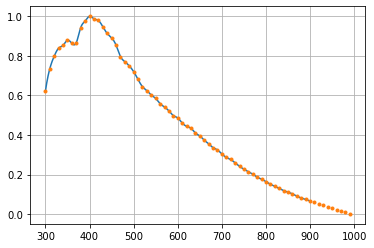

In [38]:
x = np.arange(300, 900)
xlong = np.arange(300, 1000, 10)
plt.plot(x, f_pde(x))

plt.plot(xlong, f_pde_extrapolate(xlong), '.')
plt.grid()

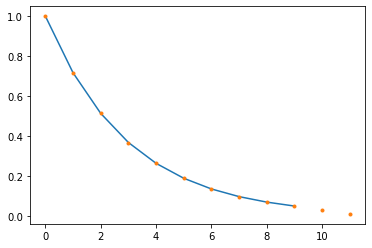

In [23]:
from scipy import interpolate
x = np.arange(0,10)
y = np.exp(-x/3.0)

f = interpolate.interp1d(x, y, fill_value='extrapolate')

x_long = np.arange(0, 12, 1)

plt.plot(x, y)
plt.plot(x_long, f(x_long), '.')

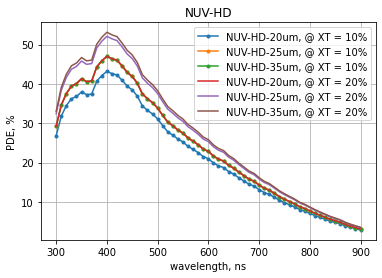

In [24]:
plt.plot(pde[:,0], 42.25*pde[:,2]/f_pde(420), '.-', label = 'NUV-HD-20um, @ XT = 10%')
plt.plot(pde[:,0], 46*pde[:,2]/f_pde(420), '.-', label = 'NUV-HD-25um, @ XT = 10%')
plt.plot(pde[:,0], 46*pde[:,2]/f_pde(420), '.-', label = 'NUV-HD-35um, @ XT = 10%')

plt.plot(pde[:,0], 46*pde[:,2]/f_pde(420), label = 'NUV-HD-20um, @ XT = 20%')
plt.plot(pde[:,0], 51*pde[:,2]/f_pde(420), label = 'NUV-HD-25um, @ XT = 20%')
plt.plot(pde[:,0], 52*pde[:,2]/f_pde(420), label = 'NUV-HD-35um, @ XT = 20%')


plt.legend()
plt.grid()
plt.xlabel("wavelength, ns")
plt.ylabel("PDE, %")
plt.title('NUV-HD')
plt.savefig('PDE_NUVHD.png', dpi = 200)

In [25]:
f_nuv_hd_20um_10xt = interp1d(pde[:,0], 0.4225*pde[:,2]/f_pde(420), kind='cubic')
f_nuv_hd_25um_10xt = interp1d(pde[:,0], 0.46*pde[:,2]/f_pde(420), kind='cubic')
f_nuv_hd_35um_10xt = interp1d(pde[:,0], 0.46*pde[:,2]/f_pde(420), kind='cubic')

f_nuv_hd_20um_20xt = interp1d(pde[:,0], 0.46*pde[:,2]/f_pde(420), kind='cubic')
f_nuv_hd_25um_20xt = interp1d(pde[:,0], 0.51*pde[:,2]/f_pde(420), kind='cubic')
f_nuv_hd_35um_20xt = interp1d(pde[:,0], 0.52*pde[:,2]/f_pde(420), kind='cubic')

In [26]:
f_nuv_hd_20um_10xt = interp1d(pde[:,0], 0.4225*pde[:,2]/f_pde(420), fill_value='extrapolate')
f_nuv_hd_25um_10xt = interp1d(pde[:,0], 0.46*pde[:,2]/f_pde(420), fill_value='extrapolate')
f_nuv_hd_35um_10xt = interp1d(pde[:,0], 0.46*pde[:,2]/f_pde(420), fill_value='extrapolate')

f_nuv_hd_20um_20xt = interp1d(pde[:,0], 0.46*pde[:,2]/f_pde(420), fill_value='extrapolate')
f_nuv_hd_25um_20xt = interp1d(pde[:,0], 0.51*pde[:,2]/f_pde(420), fill_value='extrapolate')
f_nuv_hd_35um_20xt = interp1d(pde[:,0], 0.52*pde[:,2]/f_pde(420), fill_value='extrapolate')

In [27]:
wl_nsb, nsb = read_data('/home/andrii/work/sim_telarray/analysis/spectrums/Spectra_NSB_ref.txt', 4)

In [28]:
def get_nsb_in(nsb_spectrum, wl_nsb, f_pde, wl_array):
    
    nsb_integral = np.zeros(len(nsb_spectrum))
    nsb_integral_pde_40um = np.zeros(len(nsb_spectrum))
    
    for point in range(len(nsb_spectrum)):
        if point>0:
            wl_test = nsb_spectrum[point]
            nsb_integral[point] = nsb_integral[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb_spectrum[point]
            #if wl_nsb[point]> wl_array[0] and wl_nsb[point] < wl_array[-1]:
            if wl_nsb[point]> wl_array[0] :
                nsb_integral_pde_40um[point] = nsb_integral_pde_40um[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb_spectrum[point]*f_pde(wl_nsb[point])
            #elif wl_nsb[point] >= wl_array[-1]:
            #    nsb_integral_pde_40um[point] = nsb_integral_pde_40um[point-1]
                
    return nsb_integral, nsb_integral_pde_40um
        

In [29]:
nsb_integral, nsb_integral_20um_10px = get_nsb_in(nsb, wl_nsb, f_nuv_hd_20um_10xt, pde[:,0])
nsb_integral, nsb_integral_25um_10px = get_nsb_in(nsb, wl_nsb, f_nuv_hd_25um_10xt, pde[:,0])
nsb_integral, nsb_integral_35um_10px = get_nsb_in(nsb, wl_nsb, f_nuv_hd_35um_10xt, pde[:,0])

nsb_integral, nsb_integral_20um_20px = get_nsb_in(nsb, wl_nsb, f_nuv_hd_20um_20xt, pde[:,0])
nsb_integral, nsb_integral_25um_20px = get_nsb_in(nsb, wl_nsb, f_nuv_hd_25um_20xt, pde[:,0])
nsb_integral, nsb_integral_35um_20px = get_nsb_in(nsb, wl_nsb, f_nuv_hd_35um_20xt, pde[:,0])

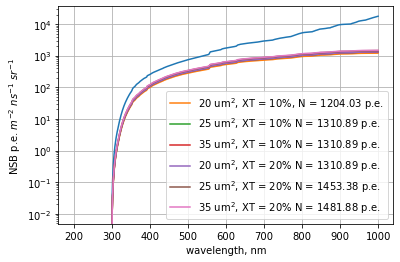

In [34]:
plt.plot(wl_nsb, nsb_integral)

plt.plot(wl_nsb, nsb_integral_20um_10px, '-', label = '20 um$^2$, XT = 10%, N = {:.2f} p.e.'.format(nsb_integral_20um_10px[-1]))
plt.plot(wl_nsb, nsb_integral_25um_10px, '-', label = '25 um$^2$, XT = 10% N = {:.2f} p.e.'.format(nsb_integral_25um_10px[-1]))
plt.plot(wl_nsb, nsb_integral_35um_10px, '-', label = '35 um$^2$, XT = 10% N = {:.2f} p.e.'.format(nsb_integral_35um_10px[-1]))

plt.plot(wl_nsb, nsb_integral_20um_20px, '-', label = '20 um$^2$, XT = 20% N = {:.2f} p.e.'.format(nsb_integral_20um_20px[-1]))
plt.plot(wl_nsb, nsb_integral_25um_20px, '-', label = '25 um$^2$, XT = 20% N = {:.2f} p.e.'.format(nsb_integral_25um_20px[-1]))
plt.plot(wl_nsb, nsb_integral_35um_20px, '-', label = '35 um$^2$, XT = 20% N = {:.2f} p.e.'.format(nsb_integral_35um_20px[-1]))


plt.yscale('log')
plt.ylabel('NSB p.e. $m^{-2}$ $ns^{-1}$ $sr^{-1}$')
plt.xlabel('wavelength, nm')
plt.grid()
plt.legend()
plt.savefig('NSB_integrated_PDE.png', dpi = 200)

In [31]:
def get_nsb_pe(integral, safe_factor):
    return integral*safe_factor*(3.14*pow(3./930.,2))*0.11

In [32]:
print('NBS in photons : {:.3f} MHz, for 20 um device, XT = 10%'.format(1000*get_nsb_pe(nsb_integral_20um_10px[-1], 6)))
print('NBS in photons : {:.3f} MHz, for 25 um device, XT = 10%'.format(1000*get_nsb_pe(nsb_integral_25um_10px[-1], 6)))
print('NBS in photons : {:.3f} MHz, for 35 um device, XT = 10%'.format(1000*get_nsb_pe(nsb_integral_35um_10px[-1], 6)))
print('=======================================================')
print('NBS in photons : {:.3f} MHz, for 20 um device, XT = 20%'.format(1000*get_nsb_pe(nsb_integral_20um_20px[-1], 6)))
print('NBS in photons : {:.3f} MHz, for 25 um device, XT = 20%'.format(1000*get_nsb_pe(nsb_integral_25um_20px[-1], 6)))
print('NBS in photons : {:.3f} MHz, for 35 um device, XT = 20%'.format(1000*get_nsb_pe(nsb_integral_35um_20px[-1], 6)))

NBS in photons : 25.965 MHz, for 20 um device, XT = 10%
NBS in photons : 28.269 MHz, for 25 um device, XT = 10%
NBS in photons : 28.269 MHz, for 35 um device, XT = 10%
NBS in photons : 28.269 MHz, for 20 um device, XT = 20%
NBS in photons : 31.342 MHz, for 25 um device, XT = 20%
NBS in photons : 31.957 MHz, for 35 um device, XT = 20%


In [ ]:
nsb_integral = np.zeros(len(nsb))
nsb_integral_pde_40um = np.zeros(len(nsb))
nsb_integral_pde_75um = np.zeros(len(nsb))

nsb_integral_pde_40um_bf = np.zeros(len(nsb))
nsb_integral_pde_75um_bf = np.zeros(len(nsb))

for point in range(len(nsb)):
    if point>0:
        wl_test = nsb[point]
        nsb_integral[point] = nsb_integral[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]
        if wl_nsb[point]> wl_40um[0]:
            nsb_integral_pde_40um[point] = nsb_integral_pde_40um[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]*f_nuv_hd_40um(wl_nsb[point])
            nsb_integral_pde_40um_bf[point] = nsb_integral_pde_40um_bf[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]*f_nuv_hd_40um(wl_nsb[point])*f_borofloat(wl_nsb[point])
        
        if wl_nsb[point]> wl_75um[0]:
            nsb_integral_pde_75um[point] = nsb_integral_pde_75um[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]*f_nuv_hd_75um(wl_nsb[point])
            nsb_integral_pde_75um_bf[point] = nsb_integral_pde_75um_bf[point-1] + (wl_nsb[point] - wl_nsb[point-1])*nsb[point]*f_nuv_hd_75um(wl_nsb[point])*f_borofloat(wl_nsb[point])

Text(0.5, 1.0, 'NSB spectrum for SST1M camera paper')

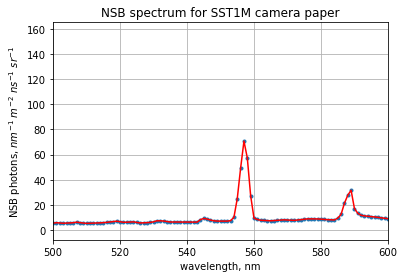

In [48]:
f_nsb = interp1d(wl_nsb, nsb, kind='cubic')
wl = np.arange(200, 1000, 1)

plt.plot(wl_nsb, nsb, '.')
plt.plot(wl, f_nsb(wl), 'r-')
plt.grid()
plt.xlim(500, 600)
plt.ylabel('NSB photons, $nm^{-1}$ $m^{-2}$ $ns^{-1}$ $sr^{-1}$')
plt.xlabel('wavelength, nm')
plt.title('NSB spectrum for SST1M camera paper')

In [50]:
wl_nsb[300:305]

[500.0, 501.0, 502.0, 503.0, 504.0]

In [53]:
wl_range = [300, 1000]

wl = np.arange(wl_range[0], wl_range[1], 1)

for point in wl:
    print(point)

300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
